## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from path_explain import utils
utils.set_up_environment(visible_devices='3')

In [ ]:
import tensorflow as tf
import tensorflow_datasets
import numpy as np
import scipy
from transformers import *
from plot.text import text_plot

## Data and Model Loading

In [ ]:
task = 'sst-2'
num_labels = len(glue_processors[task]().get_labels())

In [ ]:
config = BertConfig.from_pretrained('.', num_labels=num_labels, hidden_size=60)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertForSequenceClassification.from_pretrained('.', config=config)

In [ ]:
data, info = tensorflow_datasets.load('glue/sst2', with_info=True)

In [ ]:
train_dataset = glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, task=task)
valid_dataset = glue_convert_examples_to_features(data['validation'], tokenizer, max_length=128, task=task)
valid_dataset = valid_dataset.batch(16)

## Model Evaluation

In [8]:
valid_pred = model.predict(valid_dataset)

In [9]:
valid_input = []
valid_labels = []
for batch in valid_dataset:
    valid_input.append(batch[0])
    valid_labels.append(batch[1].numpy())
valid_labels_np = np.concatenate(valid_labels, axis=0)

In [10]:
valid_pred_max = np.argmax(valid_pred, axis=-1)
accuracy = np.sum(valid_pred_max == valid_labels_np) / len(valid_labels_np)

positive_mask = valid_labels_np == 1
positive_accuracy = np.sum(valid_pred_max[positive_mask] == valid_labels_np[positive_mask]) / np.sum(positive_mask)

negative_mask = valid_labels_np == 0
negative_accuracy = np.sum(valid_pred_max[negative_mask] == valid_labels_np[negative_mask]) / np.sum(negative_mask)

print('Validation Accuracy: {:.4f}'.format(accuracy))
print('Positive Sentiment Accuracy: {:.4f}'.format(positive_accuracy))
print('Negative Sentiment Accuracy: {:.4f}'.format(negative_accuracy))

Validation Accuracy: 0.7993
Positive Sentiment Accuracy: 0.8243
Negative Sentiment Accuracy: 0.7734


In [11]:
batch_conf = valid_pred[:16]
batch_conf = scipy.special.softmax(batch_conf, axis=-1)
batch_pred = np.argmax(batch_conf, axis=-1)
batch_labels = valid_labels[0]
batch_input = valid_input[0]
batch_ids = batch_input['input_ids']
batch_baseline = np.zeros((1, 128), dtype=np.int64)

In [12]:
tf.where(batch_ids[0] == 0)[0]

<tf.Tensor: id=220104, shape=(1,), dtype=int64, numpy=array([28])>

In [14]:
def embedding_model(batch_ids):
    batch_token_types = tf.zeros(batch_ids.shape)

    batch_embedding = model.bert.embeddings([batch_ids,
                                             None,
                                             batch_token_types])
    return batch_embedding

In [15]:
batch_embedding = embedding_model(batch_ids)

In [16]:
baseline_embedding = embedding_model(batch_baseline)

In [15]:
def prediction_model(batch_embedding):
    extended_attention_mask = tf.zeros(batch_embedding.shape[:2])
    extended_attention_mask = extended_attention_mask[:, tf.newaxis, tf.newaxis, :]
    extended_attention_mask = tf.cast(extended_attention_mask, tf.float32)
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    head_mask = [None] * model.bert.num_hidden_layers

    batch_encoded = model.bert.encoder([batch_embedding,
                                             extended_attention_mask,
                                             head_mask])
    batch_sequence = batch_encoded[0]
    batch_pooled   = model.bert.pooler(batch_sequence)
    batch_predictions = model.classifier(batch_pooled)
    return batch_predictions

In [16]:
batch_predictions = prediction_model(batch_embedding)

In [17]:
with tf.GradientTape() as tape:
    tape.watch(batch_embedding)
    batch_predictions = prediction_model(batch_embedding)
batch_gradients = tape.gradient(batch_predictions, batch_embedding)

In [18]:
from path_explain.path_explainer_tf import PathExplainerTF

In [19]:
explainer = PathExplainerTF(prediction_model)

In [20]:
attributions = explainer.attributions(inputs=batch_embedding,
                                      baseline=baseline_embedding,
                                      batch_size=8,
                                      num_samples=100,
                                      use_expectation=False,
                                      output_indices=0,
                                      verbose=True)

100%|██████████| 16/16 [01:02<00:00,  3.91s/it]


In [24]:
batch_predictions[:, 0]

<tf.Tensor: id=1455088, shape=(16,), dtype=float32, numpy=
array([-1.4696189 ,  1.7055547 , -0.69180274,  0.38995025, -0.5419994 ,
       -1.7136005 , -1.4113716 ,  0.4746249 , -0.09519354, -3.224984  ,
       -0.28440663, -1.3088676 ,  0.7439573 , -2.6171658 , -0.80482525,
       -3.4623249 ], dtype=float32)>

In [22]:
np.sum(attributions, axis=(1,2))

array([-2.36044197, -0.6022565 , -0.9838752 ,  0.63411109, -0.99284045,
       -3.15645521, -3.93296657,  0.20635184, -1.01711167, -4.69921202,
       -0.56159511, -1.41759109,  0.80907787, -3.88547647,  0.7358871 ,
       -3.96981333])

In [64]:
input_dict = tokenizer.encode_plus('This movie was very good', add_special_tokens=True)
model(np.array(input_dict['input_ids']).reshape(1, -1))

(<tf.Tensor: id=267590, shape=(1, 2), dtype=float32, numpy=array([[-0.71686935,  0.6399281 ]], dtype=float32)>,)

## Model Interpretation

In [14]:
def print_sentence(index):
    confidence = batch_conf[index]
    predicted_label = batch_pred[index]
    true_label = batch_labels[index]

    encoded_sentence = batch_ids[index].numpy()
    encoded_sentence = encoded_sentence[encoded_sentence != 0]

    print(tokenizer.decode(encoded_sentence))
    print('This sentence is:\t{}'.format('positive' if true_label == 1 else 'negative'))
    print('BERT predicts:\t\t{} (confidence {:.4f})'.format('positive' if predicted_label == 1 else 'negative',
                                                           batch_conf[index, predicted_label]))
    print('-------------------------')

In [15]:
for i in range(batch_ids.shape[0]):
    print_sentence(i)

[CLS] it confirms fincher's status as a film maker who artfully bends technical know - how to the service of psychological insight. [SEP]
This sentence is:	positive
BERT predicts:		positive (confidence 0.9985)
-------------------------
[CLS] too much of it feels unfocused and underdeveloped. [SEP]
This sentence is:	negative
BERT predicts:		negative (confidence 0.9847)
-------------------------
[CLS] a great ensemble cast can't lift this heartfelt enterprise out of the familiar. [SEP]
This sentence is:	negative
BERT predicts:		positive (confidence 0.7156)
-------------------------
[CLS] prurient playthings aside, there's little to love about this english trifle. [SEP]
This sentence is:	negative
BERT predicts:		negative (confidence 0.9527)
-------------------------
[CLS] it moves quickly, adroitly, and without fuss ; it doesn't give you time to reflect on the inanity - - and the cold war datedness - - of its premise. [SEP]
This sentence is:	positive
BERT predicts:		positive (confidence 0

In [39]:
def plot_interactions(tokens,
                      interactions,
                      vmin=None,
                      vmax=None,
                      **kwargs):
    for i in range(len(tokens)):
        select_interactions = interactions[i]
#         select_interactions[i] = 0.0
        text_plot(tokens,
                  select_interactions,
                  include_legend=False,
                  vmin=vmin,
                  vmax=vmax,
                  fontsize=16)

In [40]:
def plot_all(i):
    tokens = np.load('tokens_{}.npy'.format(i))
    attributions = np.load('attribution_{}.npy'.format(i))
    interactions = np.load('interactions_{}.npy'.format(i))

    text_plot(tokens, attributions, include_legend=True, fontsize=16)

    indices = np.where(~np.eye(interactions.shape[0], dtype=bool))
    bounds = np.max(np.abs(interactions[indices]))
    plot_interactions(tokens, interactions, vmin=-bounds, vmax=bounds, fontsize=16)

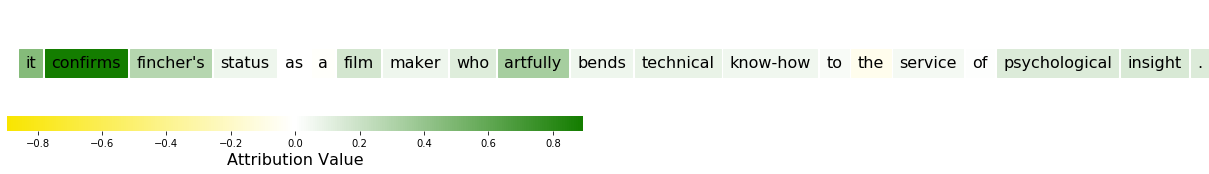

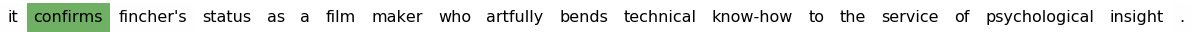

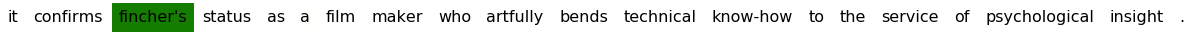

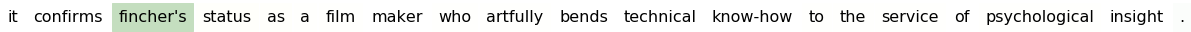

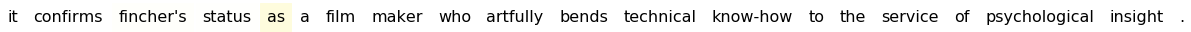

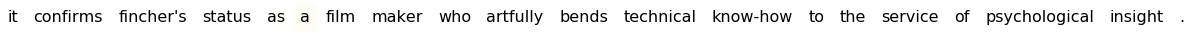

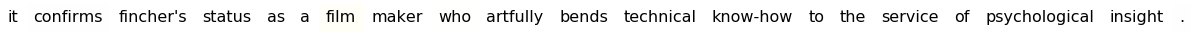

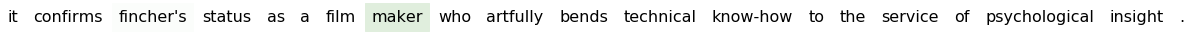

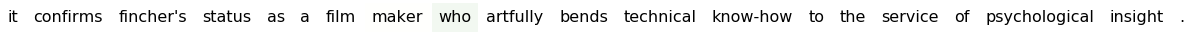

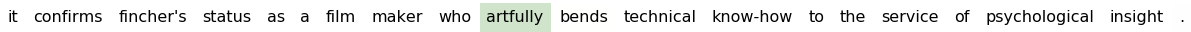

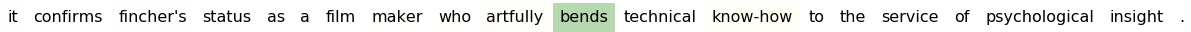

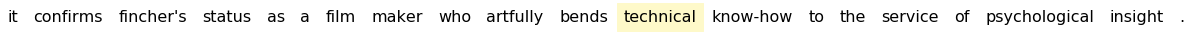

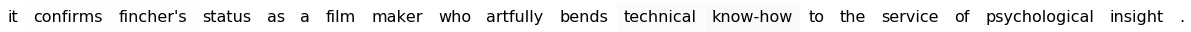

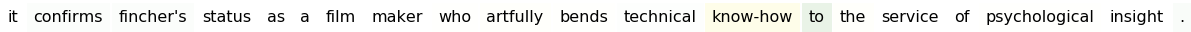

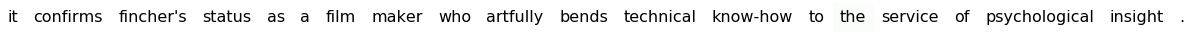

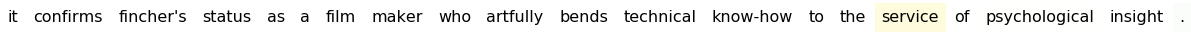

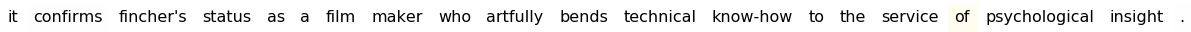

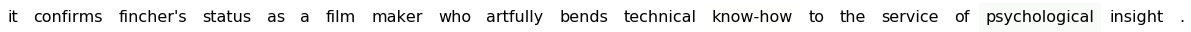

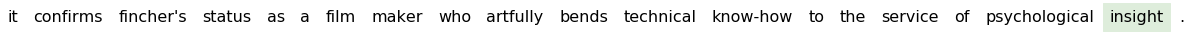

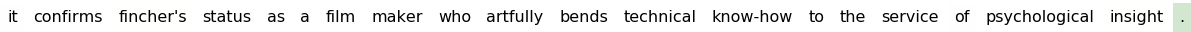

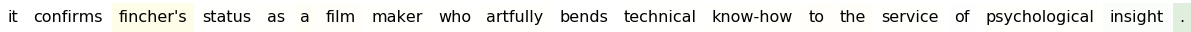

In [41]:
plot_all(0)

In [35]:
interactions = np.load('interactions_{}.npy'.format(1))

In [38]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
interactions[:-1, :-1]

array([[ 0.007,  0.09 ,  0.008,  0.005,  0.009,  0.008,  0.003, -0.01 ],
       [ 0.004, -0.017,  0.169, -0.004, -0.007, -0.018,  0.001, -0.012],
       [-0.001,  0.006,  0.012, -0.025,  0.011,  0.019,  0.003,  0.007],
       [-0.001,  0.006,  0.007,  0.014,  0.008, -0.006,  0.002, -0.001],
       [-0.005, -0.006, -0.001, -0.004,  0.004, -0.119,  0.001,  0.001],
       [-0.022,  0.028,  0.034,  0.033,  0.03 , -0.157, -0.358, -0.001],
       [ 0.004,  0.007,  0.024,  0.018,  0.021,  0.021,  0.003, -0.459],
       [-0.038,  0.017,  0.045,  0.053,  0.043,  0.062, -0.005, -0.422]])

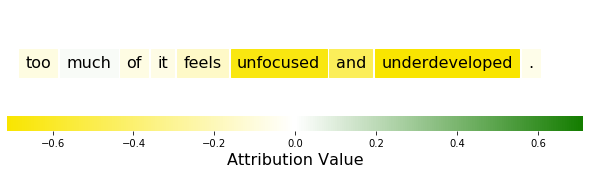

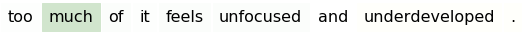

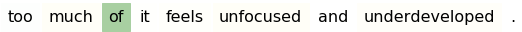

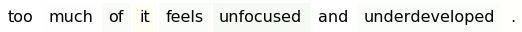

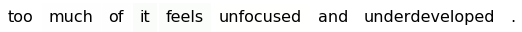

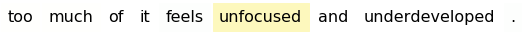

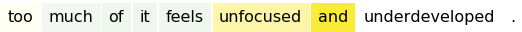

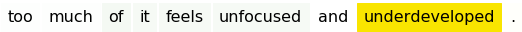

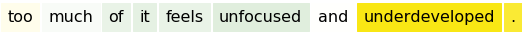

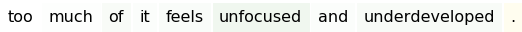

In [42]:
plot_all(1)

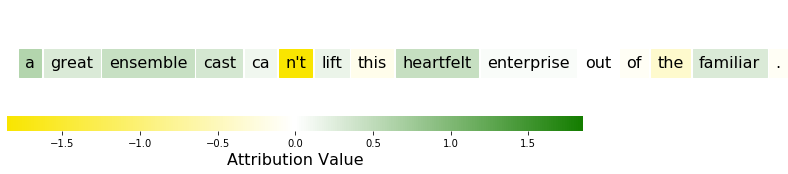

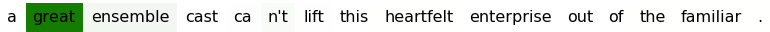

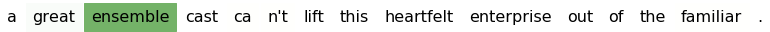

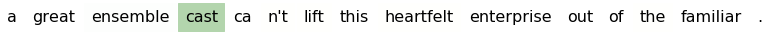

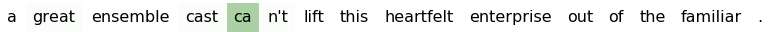

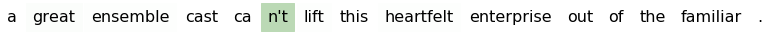

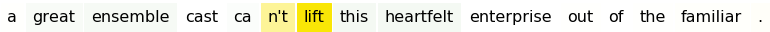

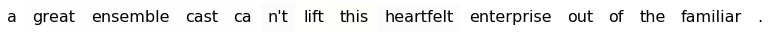

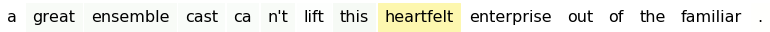

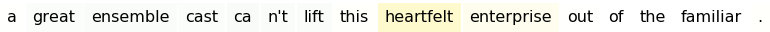

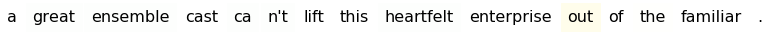

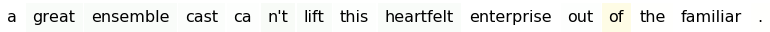

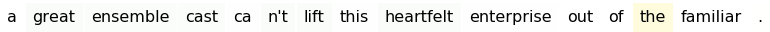

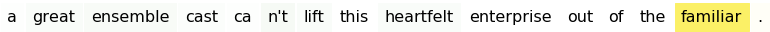

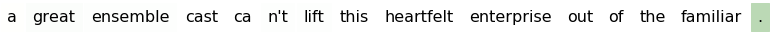

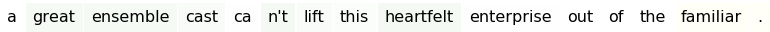

In [43]:
plot_all(2)

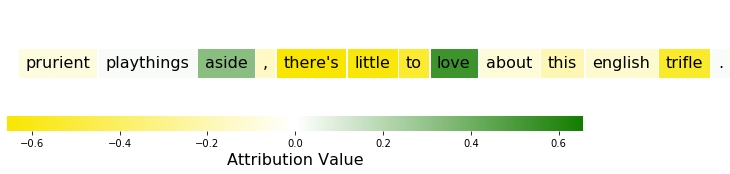

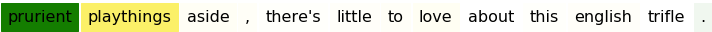

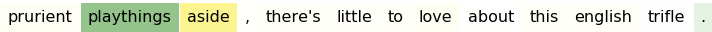

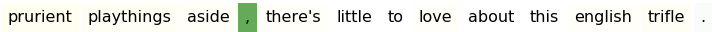

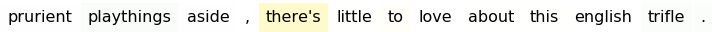

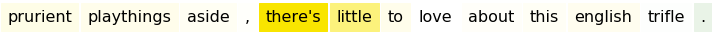

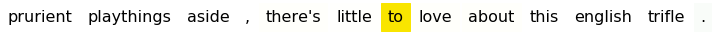

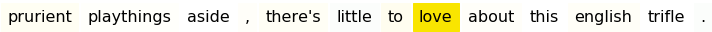

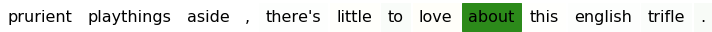

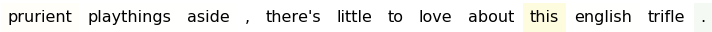

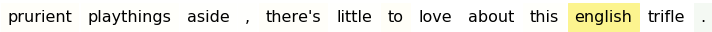

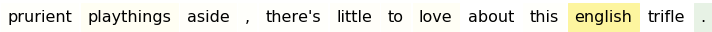

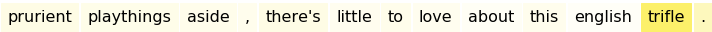

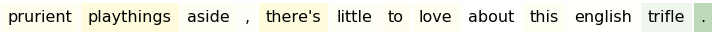

In [44]:
plot_all(3)

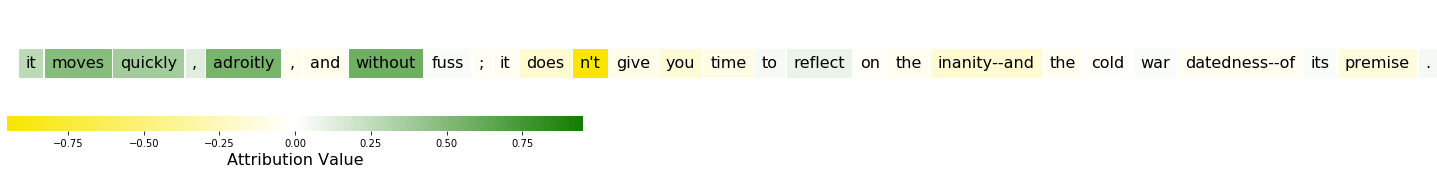

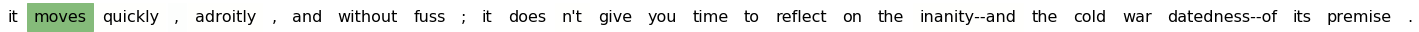

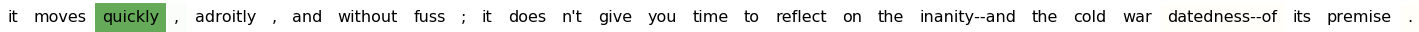

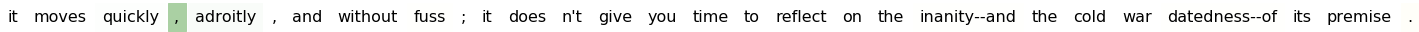

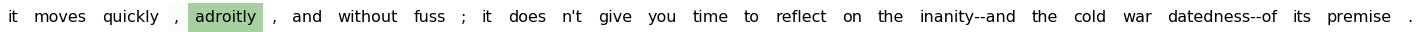

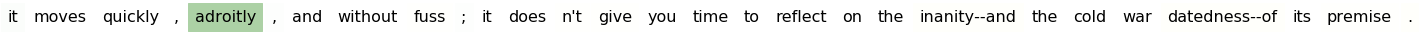

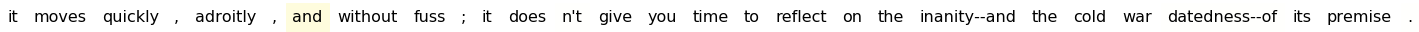

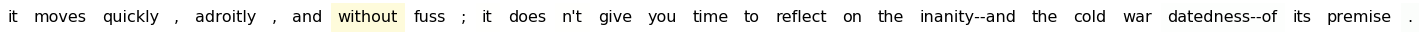

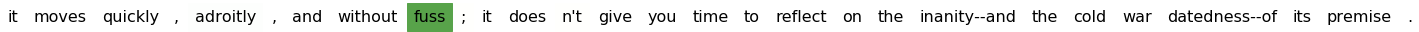

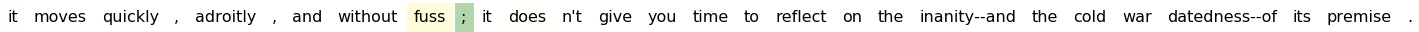

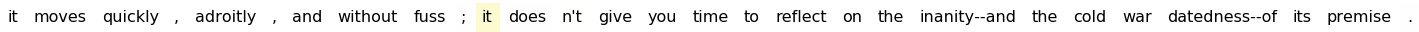

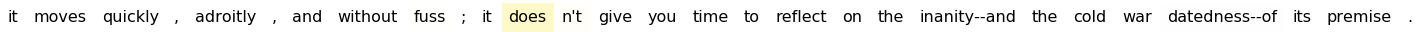

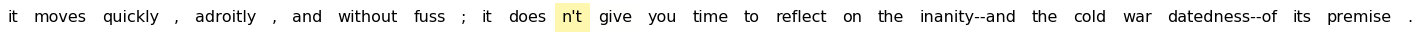

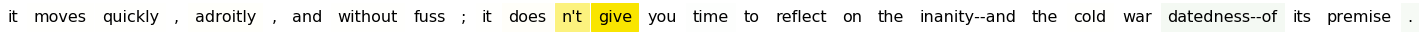

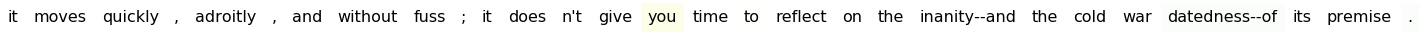

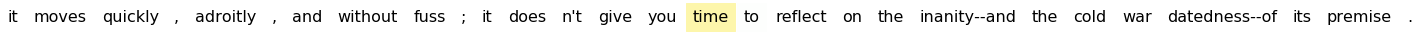

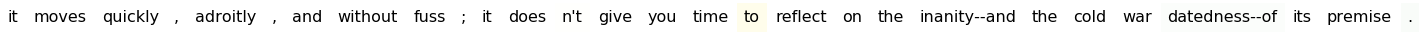

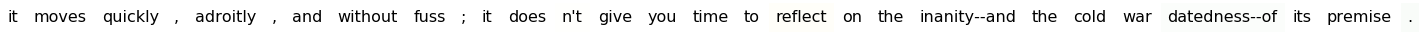

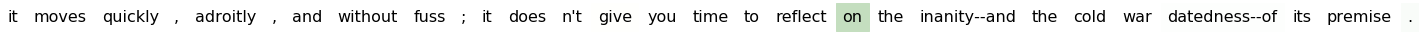

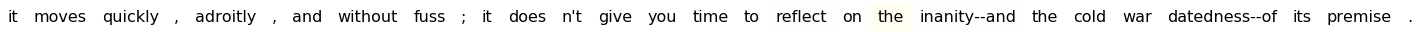

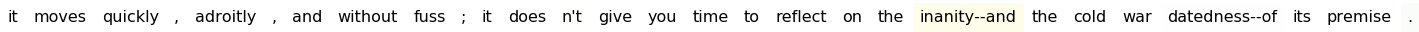

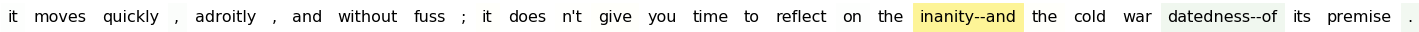

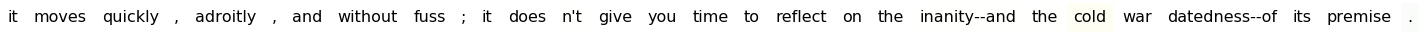

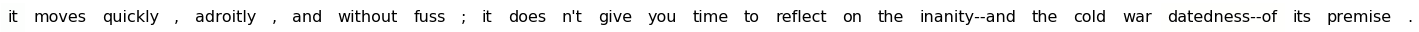

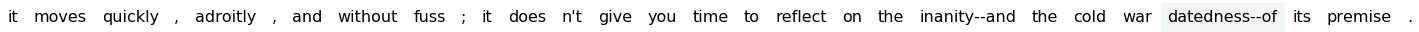

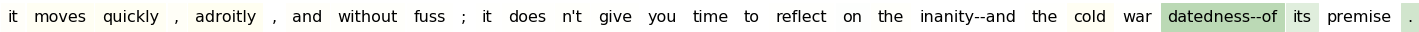

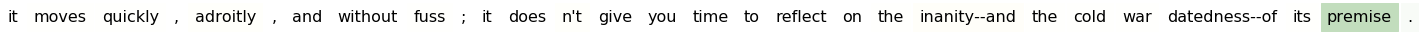

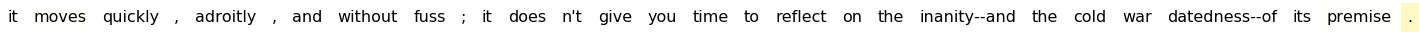

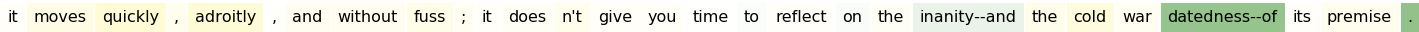

In [45]:
plot_all(4)

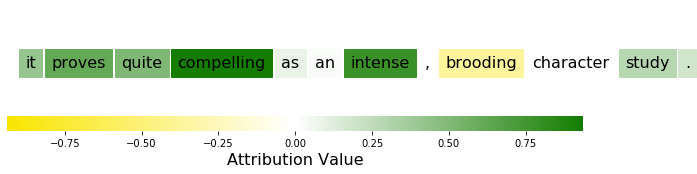

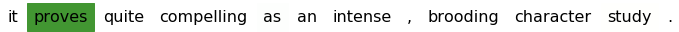

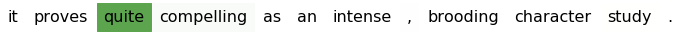

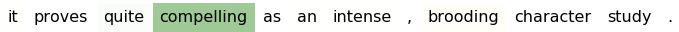

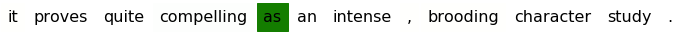

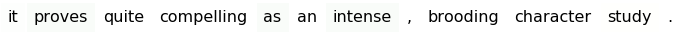

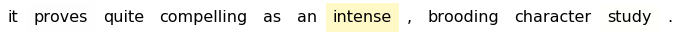

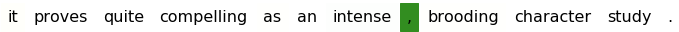

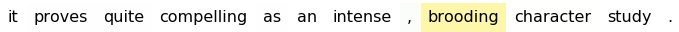

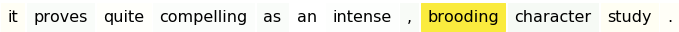

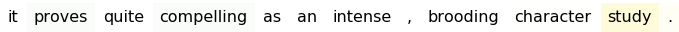

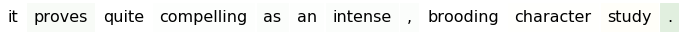

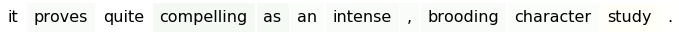

In [46]:
plot_all(5)

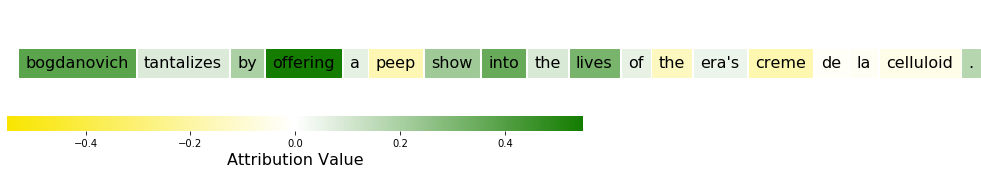

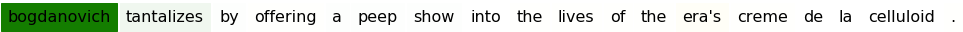

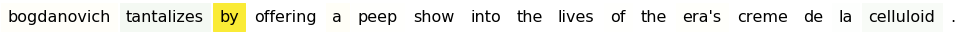

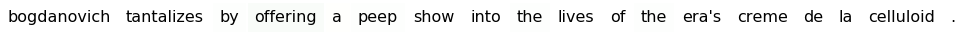

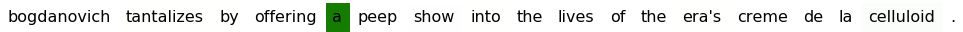

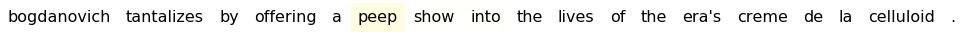

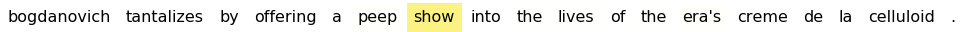

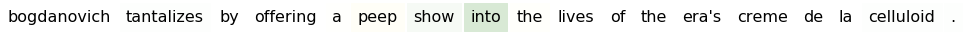

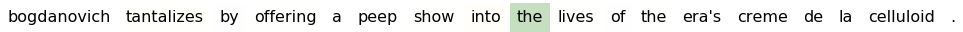

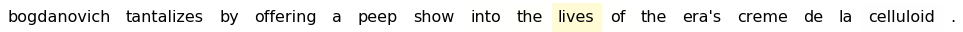

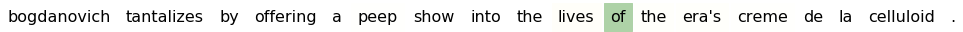

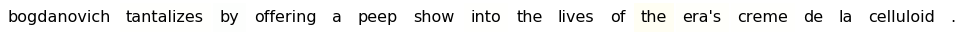

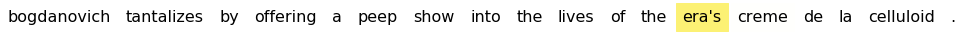

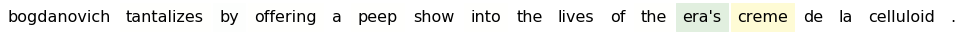

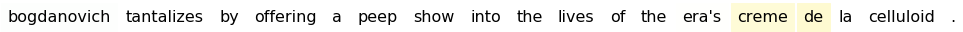

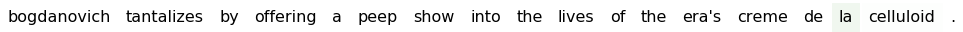

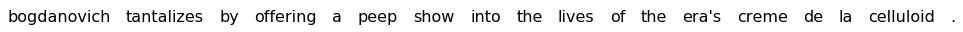

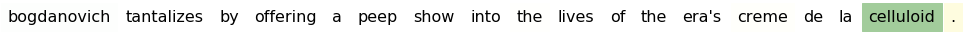

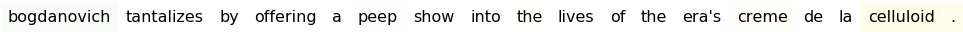

In [47]:
plot_all(6)

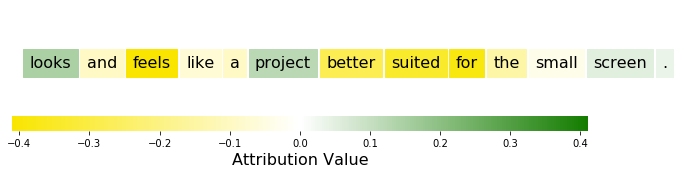

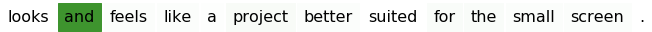

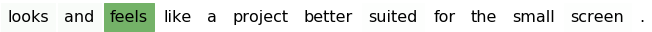

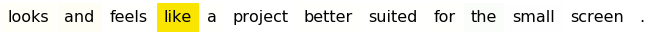

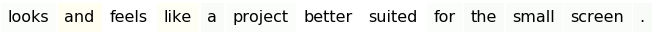

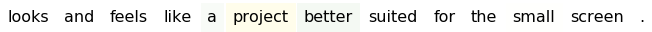

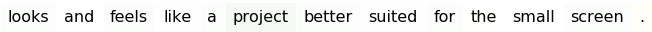

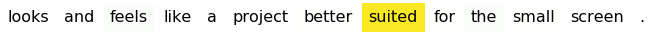

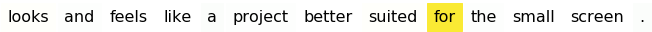

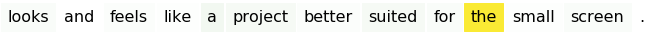

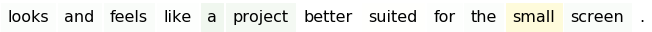

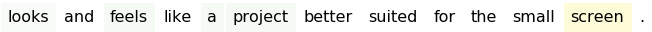

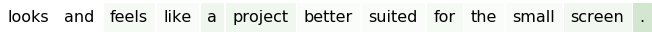

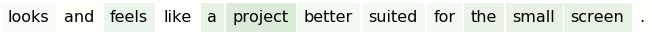

In [48]:
plot_all(7)

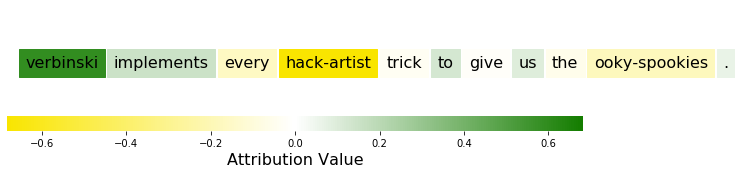

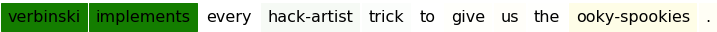

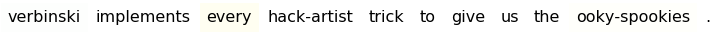

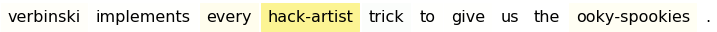

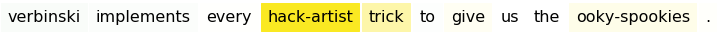

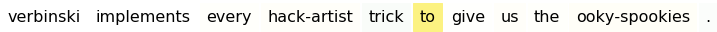

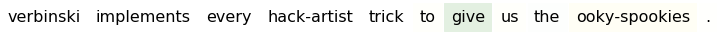

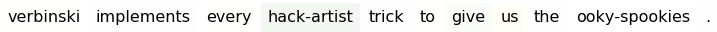

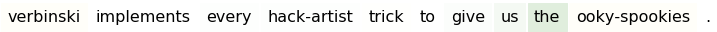

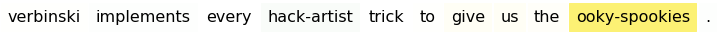

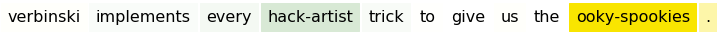

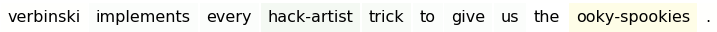

In [49]:
plot_all(8)

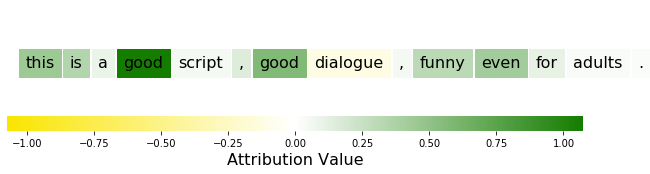

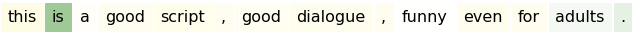

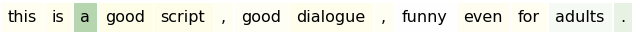

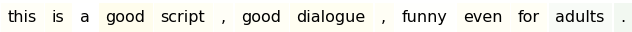

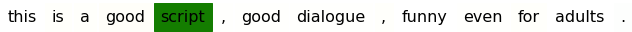

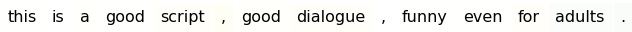

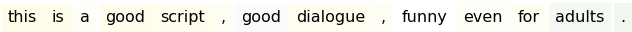

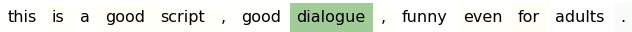

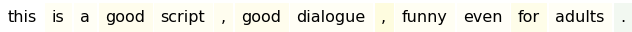

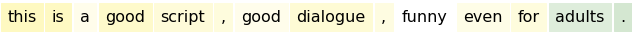

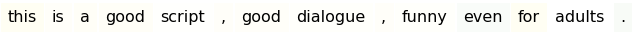

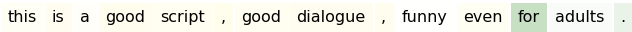

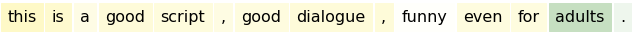

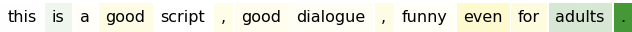

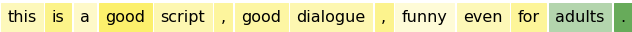

In [50]:
plot_all(9)

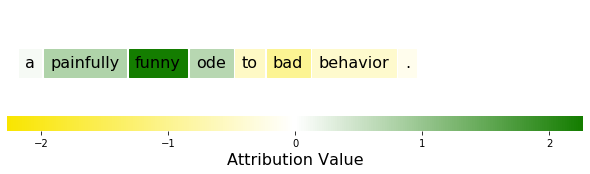

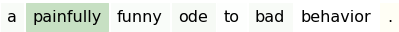

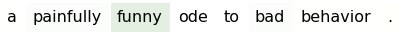

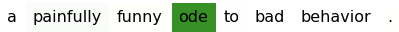

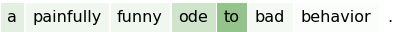

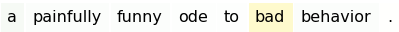

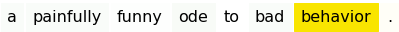

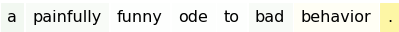

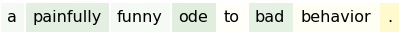

In [51]:
plot_all(10)

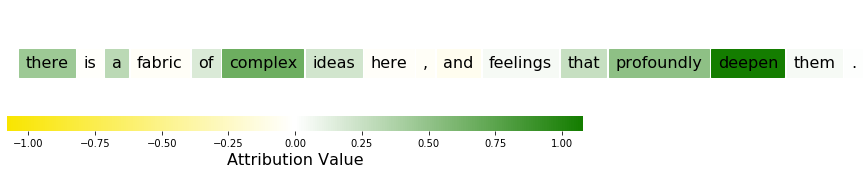

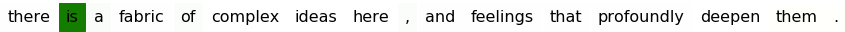

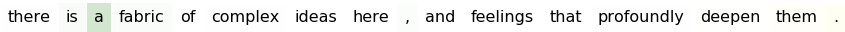

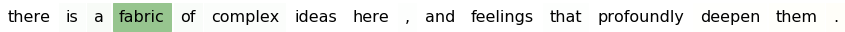

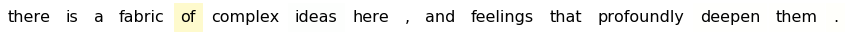

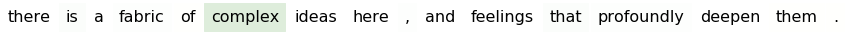

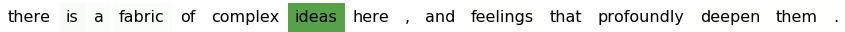

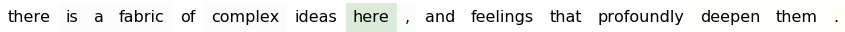

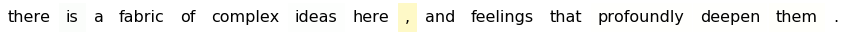

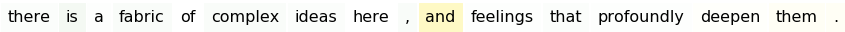

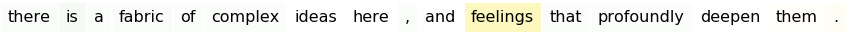

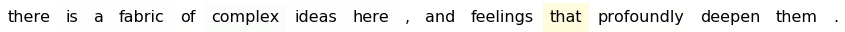

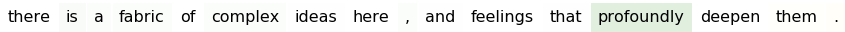

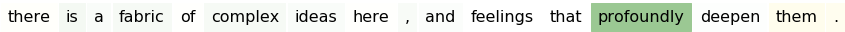

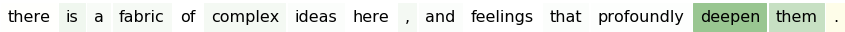

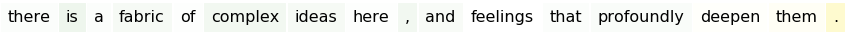

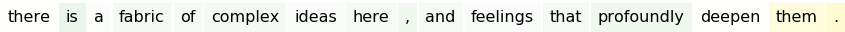

In [52]:
plot_all(11)

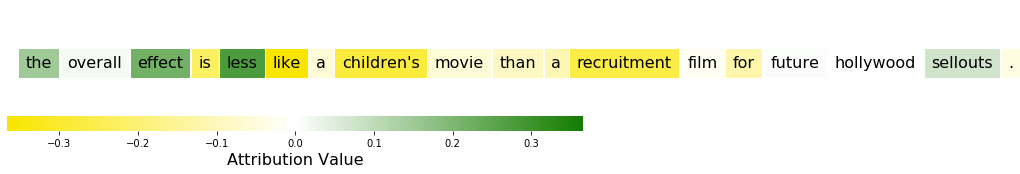

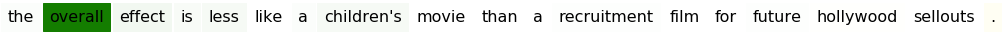

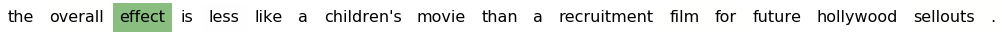

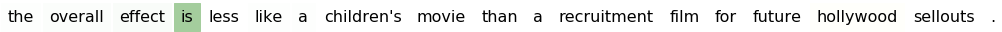

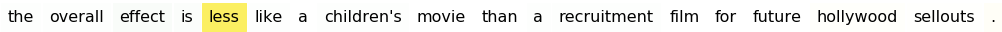

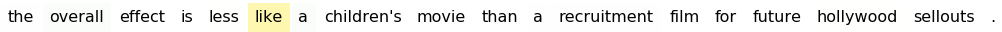

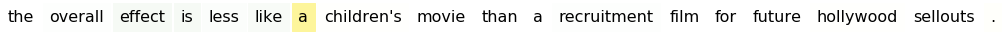

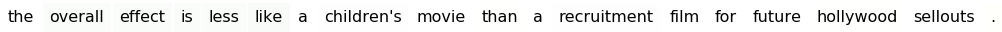

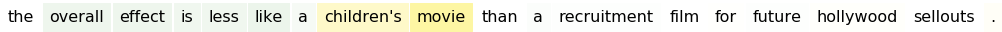

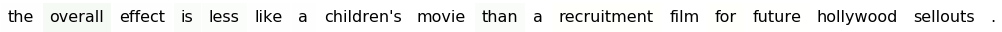

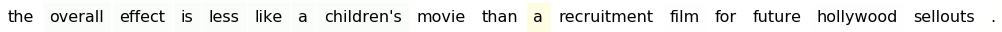

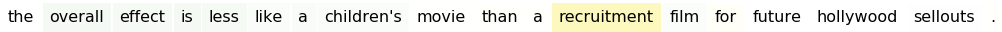

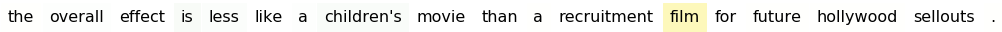

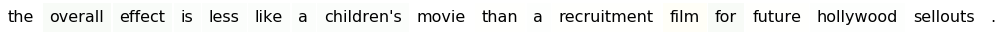

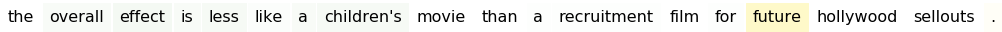

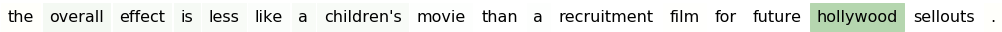

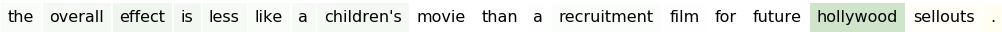

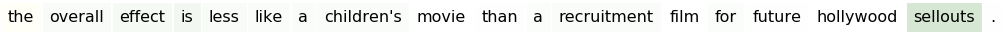

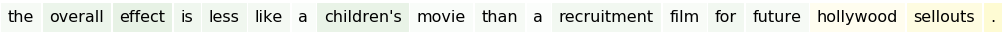

In [53]:
plot_all(12)

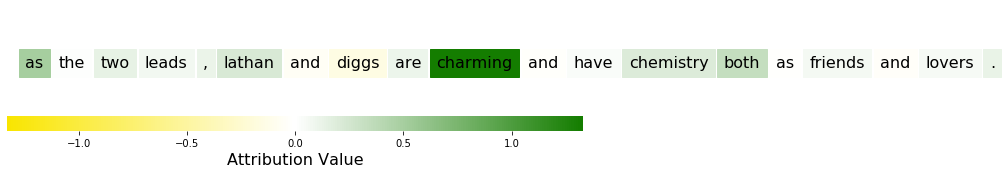

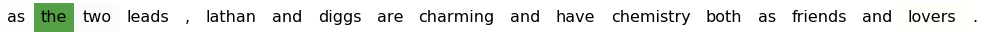

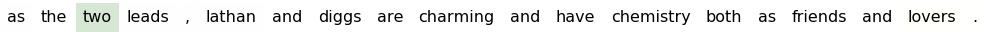

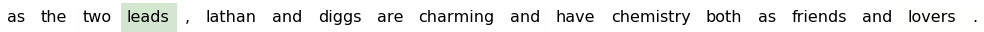

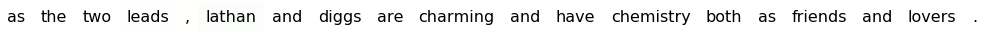

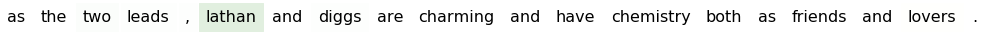

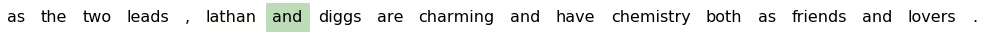

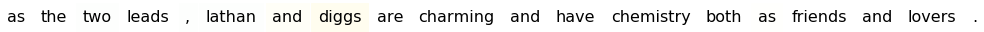

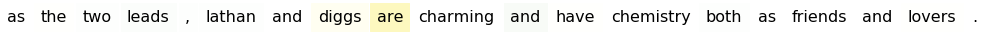

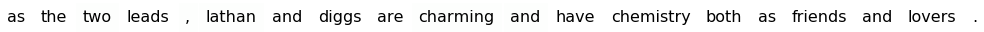

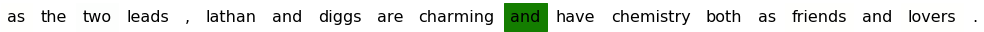

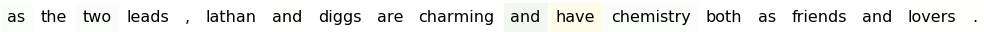

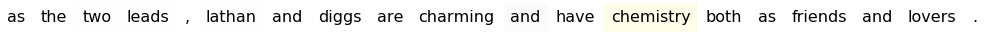

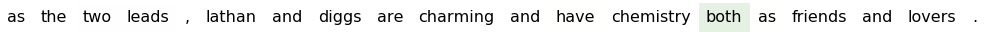

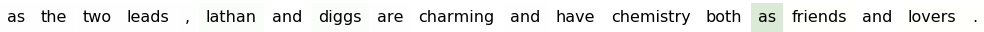

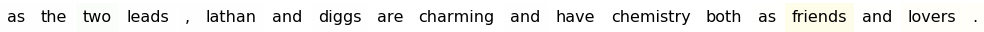

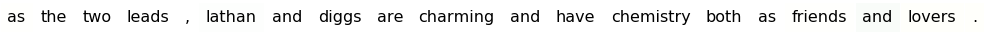

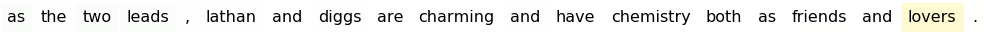

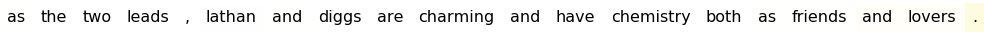

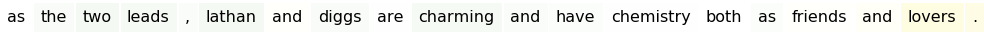

In [54]:
plot_all(13)

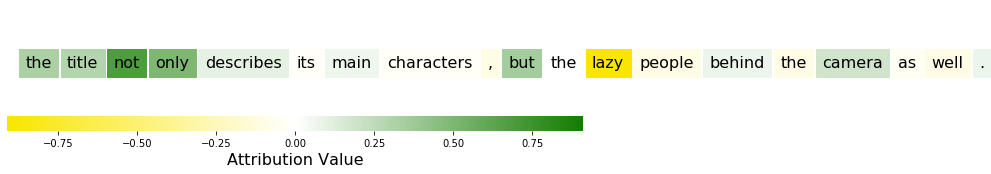

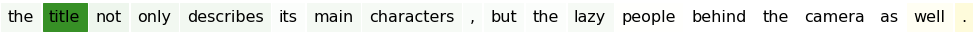

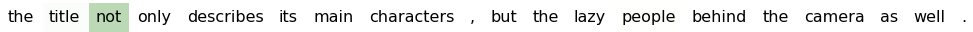

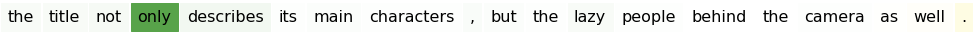

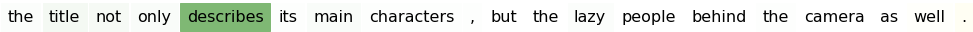

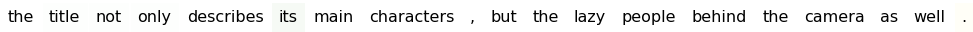

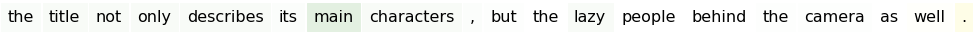

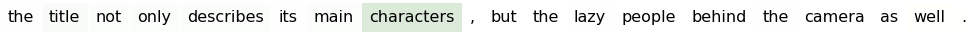

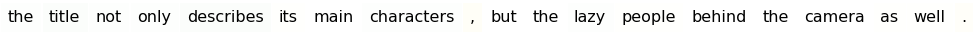

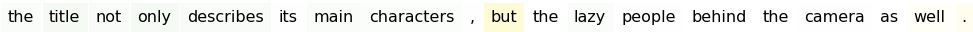

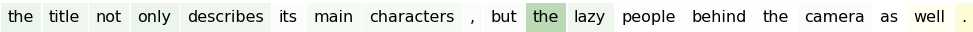

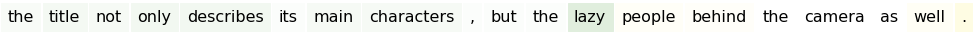

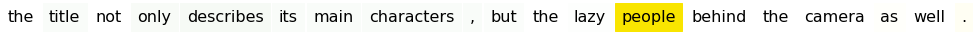

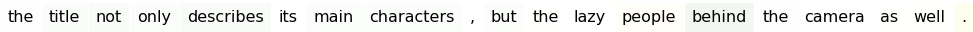

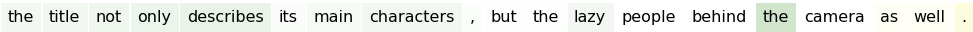

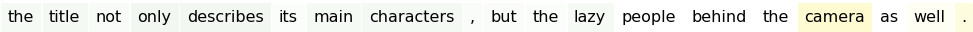

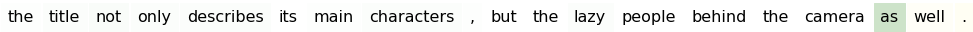

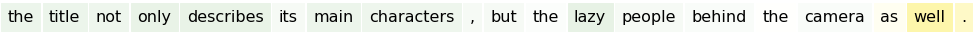

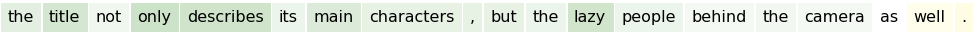

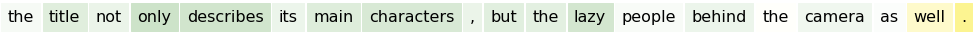

In [55]:
plot_all(14)

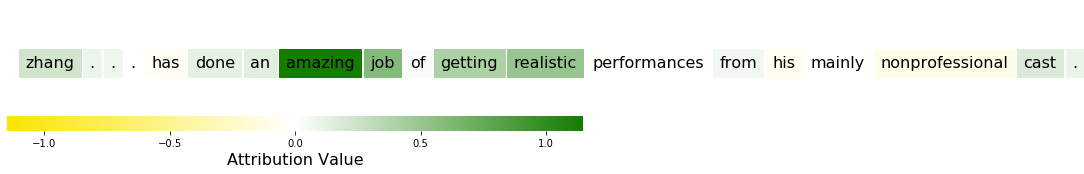

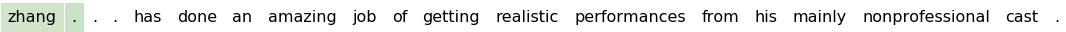

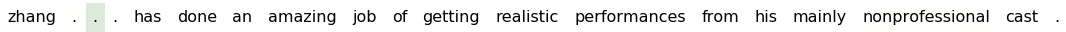

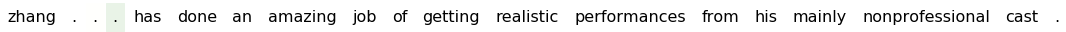

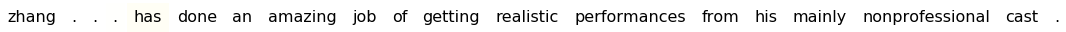

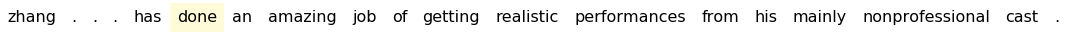

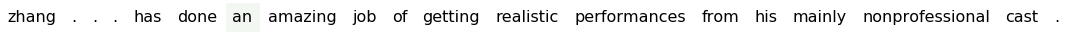

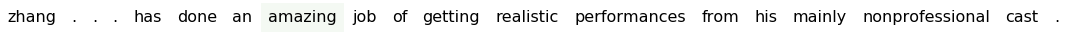

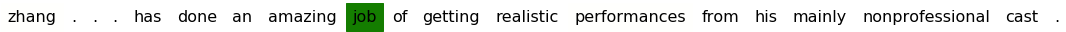

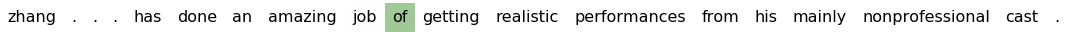

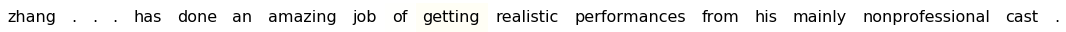

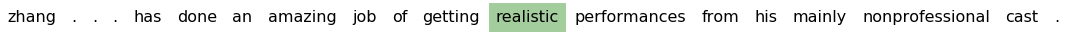

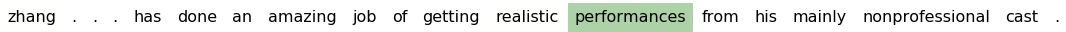

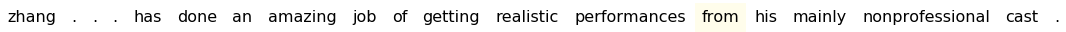

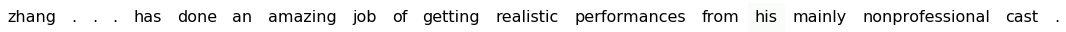

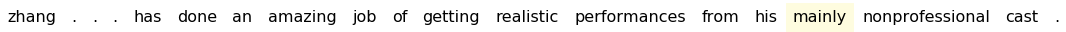

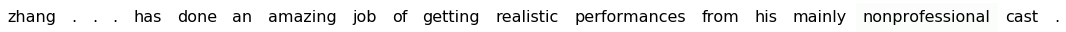

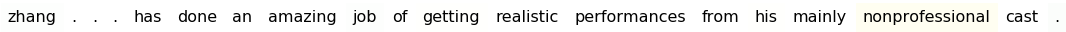

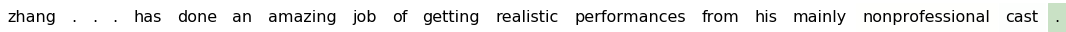

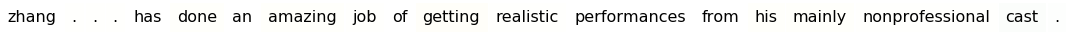

In [56]:
plot_all(15)